In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [22]:
np.random.seed(42)
num_periods = 20

In [23]:
initial_investment = 100000
mean_return = 0.08
std_dev = 0.15


In [24]:
def generate_synthetic_returns(mean_return, std_dev, num_periods):
    return np.random.normal(mean_return, std_dev, num_periods)

# Create multiple simulation paths
num_simulations = 10000
simulation_paths = np.array([
    generate_synthetic_returns(mean_return, std_dev, num_periods) for _ in range(num_simulations)
])


In [25]:
# Step 2: Monte Carlo Policy Gradient Setup
class PolicyGradientAgent:
    def __init__(self, input_dim, learning_rate=0.01):
        self.model = Sequential([
            Dense(64, activation='relu', input_shape=(input_dim,)),
            Dense(64, activation='relu'),
            Dense(1, activation='linear')
        ])
        self.optimizer = Adam(learning_rate=learning_rate)
        self.gamma = 0.99  # Discount factor

    def compute_discounted_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        cumulative = 0
        for t in reversed(range(len(rewards))):
            cumulative = cumulative * self.gamma + rewards[t]
            discounted_rewards[t] = cumulative
        return discounted_rewards

    def train(self, states, actions, rewards):
        discounted_rewards = self.compute_discounted_rewards(rewards)
        with tf.GradientTape() as tape:
            predictions = self.model(np.array(states))
            loss = tf.reduce_mean((discounted_rewards - predictions[:, 0]) ** 2)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

# Initialize Policy Gradient Agent
agent = PolicyGradientAgent(input_dim=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
num_epochs = 500
states = []
rewards = []
actions = []

for epoch in range(num_epochs):
    portfolio_value = initial_investment
    for t in range(num_periods):
        state = [portfolio_value, t / num_periods]
        action = agent.model(np.array([state]))[0, 0].numpy()
        action = max(0, min(action, portfolio_value))  # Ensure action is within bounds
        portfolio_value += action * simulation_paths[np.random.randint(0, num_simulations), t]
        reward = portfolio_value

        states.append(state)
        actions.append(action)
        rewards.append(reward)

    agent.train(states, actions, rewards)


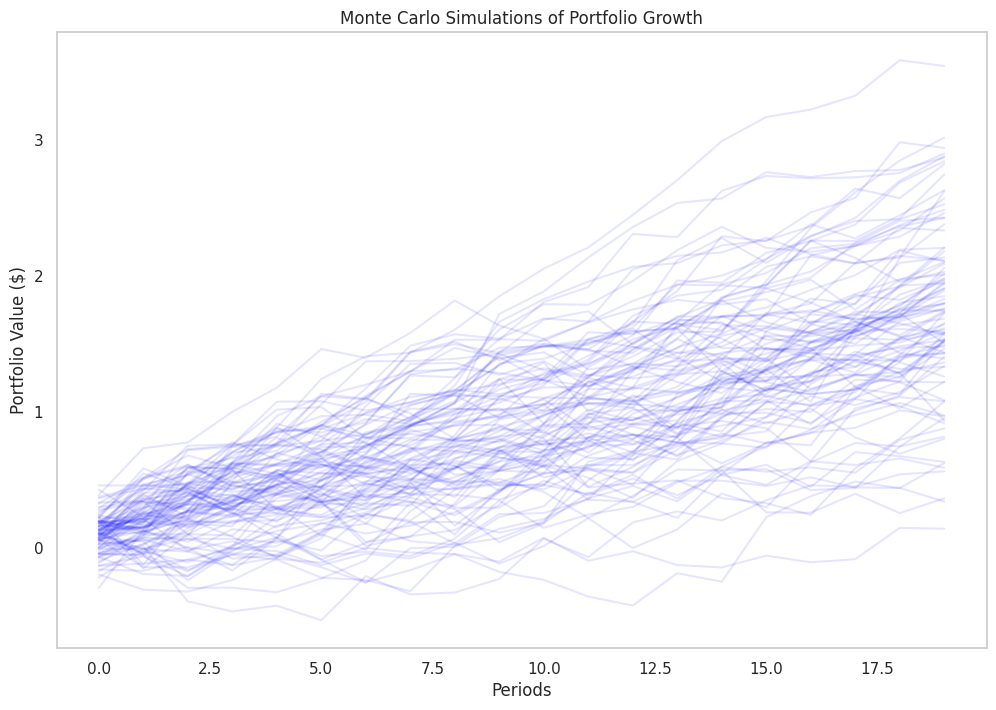

In [27]:
# Cumulative paths of portfolio values
portfolio_values = [initial_investment + np.sum(path) for path in simulation_paths]

plt.figure(figsize=(12, 8))
for i in range(100):
    plt.plot(np.cumsum(simulation_paths[i]), alpha=0.1, color='blue')
plt.title('Monte Carlo Simulations of Portfolio Growth')
plt.xlabel('Periods')
plt.ylabel('Portfolio Value ($)')
plt.grid()
plt.show()


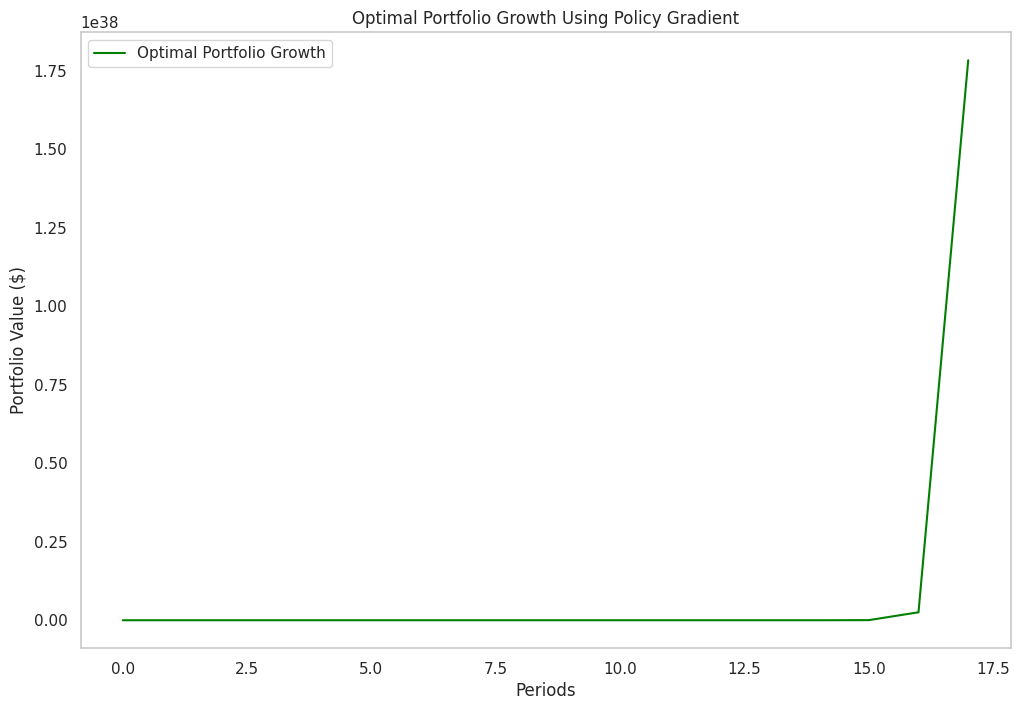

In [28]:
# Predicted optimal portfolio growth
optimal_growth = []
portfolio_value = initial_investment
for t in range(num_periods):
    state = [portfolio_value, t / num_periods]
    action = agent.model(np.array([state]))[0, 0].numpy()
    portfolio_value += action
    optimal_growth.append(portfolio_value)

plt.figure(figsize=(12, 8))
plt.plot(range(num_periods), optimal_growth, label='Optimal Portfolio Growth', color='green')
plt.title('Optimal Portfolio Growth Using Policy Gradient')
plt.xlabel('Periods')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.show()
